<a href="https://colab.research.google.com/github/galmerom/Data-Science-Tools/blob/master/Windows_Fouling_N1026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# notebook N1026

# Inputs

In [11]:
pip install mysql.connector

In [12]:
import sys
import shutil

shutil.rmtree('Data-Science-Tools',ignore_errors=True)

!git clone https://github.com/galmerom/Data-Science-Tools.git
SourceCodePath2 = 'Data-Science-Tools'
sys.path.insert(2, SourceCodePath2 )

Cloning into 'Data-Science-Tools'...
remote: Enumerating objects: 787, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 787 (delta 46), reused 1 (delta 0), pack-reused 714
Receiving objects: 100% (787/787), 823.26 KiB | 2.31 MiB/s, done.
Resolving deltas: 100% (503/503), done.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from datetime import timedelta
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
import re
import math

import charts
import transformers as TR

In [14]:
import mysql.connector

In [15]:
##### Put input file path here #####
my_path = '/gdrive/My Drive/Datasets/OurLab/Datasets/Windows_Fouling/220425_UNUM002_DW_with_NTU_base_line.csv'


# Connect to drive

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Read data

Read data and find I0

In [18]:
DW_data = pd.read_csv(my_path) # Main dataset
# correcting values using temp. finding I0
DW_data['UVH_I0_TmpCorrected'] = 3646.99345406 + (-12.10791791*DW_data['T'])
DW_data['UVL_I0_TmpCorrected'] = 3908.90246823 + (-32.60112903*DW_data['T'])
DW_data['IR_IR_t_I0_TmpCorrected'] = 3846.3408248 + (-14.44308135*DW_data['T'])
DW_data['IR_IR_s_TmpCorrected'] = 490 # There is a problem with the connection between temp. and scattering,
                                   #  so we assume constant according to an average value
DW_data['IR_ScatOverTrans_0'] = DW_data['IR_IR_s_TmpCorrected']/DW_data['IR_IR_t_I0_TmpCorrected'] 

#IR makes the light and the other photo diodes get it
DW_data['IR_UVH_I0_TmpCorrected'] = 346.51064949 + (-2.38189209*DW_data['T'])
DW_data['IR_UVL_I0_TmpCorrected'] = 52.5 # This value have no correlation with temp.

#Find real NTU
DW_data['NTU_actual'] = DW_data['comment'].str.split('_', expand=True)[2].astype(float)


In [ ]:
DW_data.info()

In [34]:
# example: Perc_IR = IR/IR_I0
DW_data['Perc_IR_IR_t'] = DW_data['IR_IR_t']/DW_data['IR_IR_t_I0_TmpCorrected']
DW_data['Perc_UVH'] = DW_data['UVH_UVH_t']/DW_data['UVH_I0_TmpCorrected']  
DW_data['Perc_UVL'] = DW_data['UVL_UVL_t']/DW_data['UVL_I0_TmpCorrected'] 
DW_data['Perc_IR_UVH'] = DW_data['IR_UVH_t']/DW_data['IR_UVH_I0_TmpCorrected']  
DW_data['Perc_IR_UVL'] = DW_data['IR_UVL_t']/DW_data['UVL_I0_TmpCorrected'] 

#Using IR we predict the NTU in the water
DW_data['IR_Predict_NTU'] = 7010.62947361 + (-7010.7520486*DW_data['Perc_IR_IR_t'])
DW_data['IR_Predict_NTU'] = np.where(DW_data['IR_Predict_NTU']>0,DW_data['IR_Predict_NTU'],0)
#Using UVH we predict the NTU in the water
DW_data['UVH_Predict_NTU'] = 21063.00 + (-42559.57*DW_data['Perc_IR_UVH'])+21494.43*(DW_data['Perc_IR_UVH']**2)
DW_data['UVH_Predict_NTU'] = np.where(DW_data['UVH_Predict_NTU']>0,DW_data['UVH_Predict_NTU'],0)
#Using UVL we predict the NTU in the water
DW_data['UVL_Predict_NTU'] = -209.48529924 + (11693.36*DW_data['Perc_IR_UVL'])
DW_data['UVL_Predict_NTU'] = np.where(DW_data['UVL_Predict_NTU']>0,DW_data['UVL_Predict_NTU'],0)

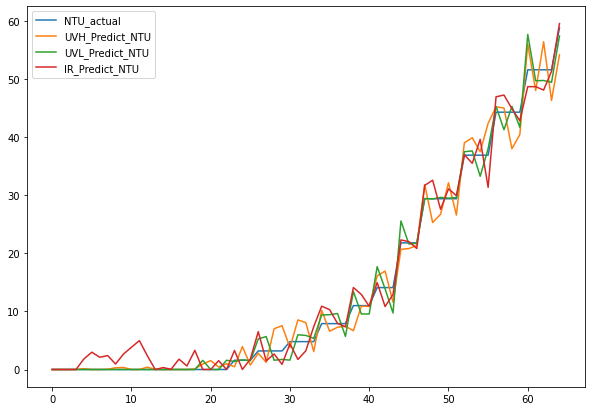

In [37]:
DW_data[['NTU_actual','UVH_Predict_NTU','UVL_Predict_NTU','IR_Predict_NTU']].plot(figsize=(10,7))

Update the UVH+UVL I0 after Temp adjustment and turbidity adjustment

In [16]:
DW_data['UVH_I0'] = DW_data['UVH_I0_corrected']*(0.99845199 + (-0.00280821*DW_data['Predict_NTU']))
DW_data['UVL_I0'] = DW_data['UVL_I0_corrected']*(0.99820843 + (-0.00292697*DW_data['Predict_NTU']))

In [17]:
DW_data['ABS_UVH'] = -1*np.log10((DW_data['UVH_UVH_t']/DW_data['UVH_I0']))
DW_data['ABS_UVL'] = -1*np.log10((DW_data['UVL_UVL_t']/DW_data['UVL_I0']))
DW_data['Norm_s_t'] = (DW_data['IR_IR_s']/DW_data['IR_IR_t']) - DW_data['IR_ScatOverTrans_0']

# מכאן נתונים ישנים

In [100]:
DW_data['ABS_UVH_i0']=DW_data_NTU[DW_data_NTU.index=="0"]['ABS_UVH'].iloc[0]
DW_data['ABS_UVL_i0']=DW_data_NTU[DW_data_NTU.index=="0"]['ABS_UVL'].iloc[0]

In [101]:
DW_data['ABS_UVH_atten'] = DW_data['ABS_UVH']/DW_data['ABS_UVH_i0']
DW_data['ABS_UVL_atten'] = DW_data['ABS_UVL']/DW_data['ABS_UVL_i0']

In [ ]:

DW_data['ABS_UVH_I0'] = DW_data[DW_data['comment']=='DW_NTU_0']
DW_data['ABS_UVH_atten'] = DW_data['ABS_UVH']/
[DW_data['comment']=='DW_NTU_0']

## Polynomal models

In [22]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [23]:
    #line
    def poly_1(x, a, b):
        return a + b*x
    #parabola
    def poly_2(x, a, b, c):
        return a + b*x + c*(x**2)
    def poly_3(x, a, b, c, d):
        return a + b*x + c*(x**2) + d*(x**3)
    def poly_4(x, a, b, c, d, e):
        return a + b*x + c*(x**2) + d*(x**3) + e*(x**4)
    def poly_5(x, a, b, c, d, e,f):
        return a + b*x + c*(x**2) + d*(x**3) + e*(x**4)+f*(x**5)
    def poly_1_no_inter(x, b):
        return  b*x
    #parabola
    def poly_2_no_inter(x, b, c):
        return b*x + c*(x**2)
    def poly_3_no_inter(x, b, c, d):
        return  b*x + c*(x**2) + d*(x**3)
    def poly_4_no_inter(x, b, c, d, e):
        return  b*x + c*(x**2) + d*(x**3) + e*(x**4)
    def poly_5_no_inter(x, b, c, d, e,f):
        return  b*x + c*(x**2) + d*(x**3) + e*(x**4)+f*(x**5)


In [24]:
def PolyFitResults(XInput,yInput):
    X = XInput
    y = yInput
    boundsVal=(0,np.inf)
    popt1, _ = curve_fit(poly_1, X, y)
    popt2, _ = curve_fit(poly_2, X, y)
    popt3, _ = curve_fit(poly_3, X, y)
    popt4, _ = curve_fit(poly_4, X, y)
    popt5, _ = curve_fit(poly_5, X, y)
    popt1_no_inter, _ = curve_fit(poly_1_no_inter, X, y)
    popt2_no_inter, _ = curve_fit(poly_2_no_inter, X, y)
    popt3_no_inter, _ = curve_fit(poly_3_no_inter, X, y)
    popt4_no_inter, _ = curve_fit(poly_4_no_inter, X, y)
    popt5_no_inter, _ = curve_fit(poly_5_no_inter, X, y)
    # popspecial = curve_fit(poly_special, X, y)
    curves=pd.DataFrame(X.apply(poly_1,a=popt1[0],b=popt1[1]))
    curves.rename({curves.columns[0]:'CF1'},axis=1,inplace=True)
    curves['CF2'] = X.apply(poly_2,a=popt2[0],b=popt2[1],c=popt2[2])
    curves['CF3'] = X.apply(poly_3,a=popt3[0],b=popt3[1],c=popt3[2],d=popt3[3])
    curves['CF4'] = X.apply(poly_4,a=popt4[0],b=popt4[1],c=popt4[2],d=popt4[3],e=popt4[4])
    curves['CF1_no_inter'] = X.apply(poly_1_no_inter,b=popt1_no_inter[0])
    curves['CF2_no_inter'] = X.apply(poly_2_no_inter,b=popt2_no_inter[0],c=popt2_no_inter[1])
    curves['CF3_no_inter'] = X.apply(poly_3_no_inter,b=popt3_no_inter[0],c=popt3_no_inter[1],d=popt3_no_inter[2])
    curves['CF4_no_inter'] = X.apply(poly_4_no_inter,b=popt4_no_inter[0],c=popt4_no_inter[1],d=popt4_no_inter[2],e=popt4_no_inter[3])
    curves['X_Input'] = XInput
    curves['y_Input'] = yInput
    curves=curves.sort_values('X_Input')

    #Create charts
    fig, axs = plt.subplots(4,3,figsize=(20,20))
    axs[0, 0].plot(curves.X_Input, curves.y_Input, '.k')
    axs[0, 0].plot(curves.X_Input, curves['CF1'], linewidth=3, color='green')
    axs[0, 0].set_title('\n'+'CF1'+'\n'+_Scoring(curves,'y_Input','CF1'))
    axs[0, 0].legend(['y_true','CF1: ${:.2f}+{:.2f}x$'.format(*popt1)],loc='best')
    axs[0, 1].plot(curves.X_Input, curves.y_Input, '.k')
    axs[0, 1].plot(curves.X_Input, curves['CF2'], linewidth=3, color='green')
    axs[0, 1].set_title('\n'+'CF2'+'\n'+_Scoring(curves,'y_Input','CF2'))
    axs[0, 1].legend(['y_true','CF2: ${:.2f}+{:.2f}x+{:.2f}x^2$'.format(*popt2)],loc='best')
    axs[0, 2].plot(curves.X_Input, curves.y_Input, '.k')
    axs[0, 2].plot(curves.X_Input, curves['CF3'], linewidth=3, color='green')
    axs[0, 2].set_title('\n'+'CF3'+'\n'+_Scoring(curves,'y_Input','CF3'))
    axs[0, 2].legend(['y_true','CF3: ${:.2f}+{:.2f}x+{:.2f}x^2+{:.2f}x^3$'.format(*popt3)],loc='best')
    axs[1, 0].plot(curves.X_Input, curves.y_Input, 'ok')
    axs[1, 0].plot(curves.X_Input, curves['CF1_no_inter'], linewidth=3, color='green')
    axs[1, 0].set_title('\n'+'CF1_no_inter'+'\n'+_Scoring(curves,'y_Input','CF1_no_inter'))
    axs[1, 0].legend(['y_true','CF1_no_inter: {:.2f}x$'.format(*popt1_no_inter)],loc='best')
    axs[1, 1].plot(curves.X_Input, curves.y_Input, 'ok')
    axs[1, 1].plot(curves.X_Input, curves['CF2_no_inter'], linewidth=3, color='green')
    axs[1, 1].set_title('\n'+'CF2_no_inter'+'\n'+_Scoring(curves,'y_Input','CF2_no_inter'))
    axs[1, 1].legend(['y_true','CF2_no_inter: {:.2f}x+{:.2f}x^2$'.format(*popt2_no_inter)],loc='best')
    axs[1, 2].plot(curves.X_Input, curves.y_Input, 'ok')
    axs[1, 2].plot(curves.X_Input, curves['CF3_no_inter'], linewidth=3, color='green')
    axs[1, 2].set_title('\n'+'CF3_no_inter'+'\n'+_Scoring(curves,'y_Input','CF3_no_inter'))
    axs[1, 2].legend(['y_true','CF3_no_inter: {:.2f}x+{:.2f}x^2+{:.2f}x^3$'.format(*popt3_no_inter)],loc='best')
    axs[2, 0].plot(curves.X_Input, curves.y_Input, 'ok')
    axs[2, 0].plot(curves.X_Input, curves['CF4'], linewidth=3, color='green')
    axs[2, 0].set_title('\n'+'CF4'+'\n'+_Scoring(curves,'y_Input','CF4'))
    axs[2, 0].legend(['y_true','CF4: ${:.2f}+{:.2f}x+{:.2f}x^2+{:.2f}x^3+{:.2f}x^4$'.format(*popt4)],loc='best')
    axs[3, 0].plot(curves.X_Input, curves.y_Input, 'ok')
    axs[3, 0].plot(curves.X_Input, curves['CF4_no_inter'], linewidth=3, color='green')
    axs[3, 0].set_title('\n'+'CF4_no_inter'+'\n'+_Scoring(curves,'y_Input','CF4_no_inter'))
    axs[3, 0].legend(['y_true','CF4_no_inter: {:.2f}x+{:.2f}x^2+{:.2f}x^3+{:.2f}x^4$'.format(*popt4_no_inter)],loc='best')
    curvesDic={'CF1':popt1,'CF2':popt2,'CF3':popt3,'CF4':popt4,'CF1_no_inter':popt1_no_inter,
               'CF2_no_inter':popt2_no_inter,'CF3_no_inter':popt3_no_inter,'CF4_no_inter':popt4_no_inter}
    BestR2=0
    for col in  curvesDic.keys():
        tmp = r2_score(curves['y_Input'], curves[col])
        if tmp>BestR2:
            BestR2=tmp
            BestCol=col

    return  (curves,curvesDic,BestCol)

def _Scoring(df,y_true,y_pred):
    r2='{:.3f}'.format(r2_score(df[y_true], df[y_pred]))
    rmse = '{:.3f}'.format(np.sqrt(mean_squared_error(df[y_true], df[y_pred])))
    return 'R-squared: '+str(r2)+'   RMSE:'+str(rmse)

In [33]:
DW_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  65 non-null     object 
 1   IR_IR_r               65 non-null     int64  
 2   IR_IR_t               65 non-null     int64  
 3   IR_IR_s               65 non-null     int64  
 4   IR_UVH_r              65 non-null     int64  
 5   IR_UVH_t              65 non-null     int64  
 6   IR_UVL_r              65 non-null     int64  
 7   IR_UVL_t              65 non-null     int64  
 8   UVH_IR_r              65 non-null     int64  
 9   UVH_IR_t              65 non-null     int64  
 10  UVH_IR_s              65 non-null     int64  
 11  UVH_UVH_r             65 non-null     int64  
 12  UVH_UVH_t             65 non-null     int64  
 13  UVH_UVL_r             65 non-null     int64  
 14  UVH_UVL_t             65 non-null     int64  
 15  UVL_IR_r              65 

In [33]:
curvesDic['CF1']

array([ -209.48529924, 11693.36830904])

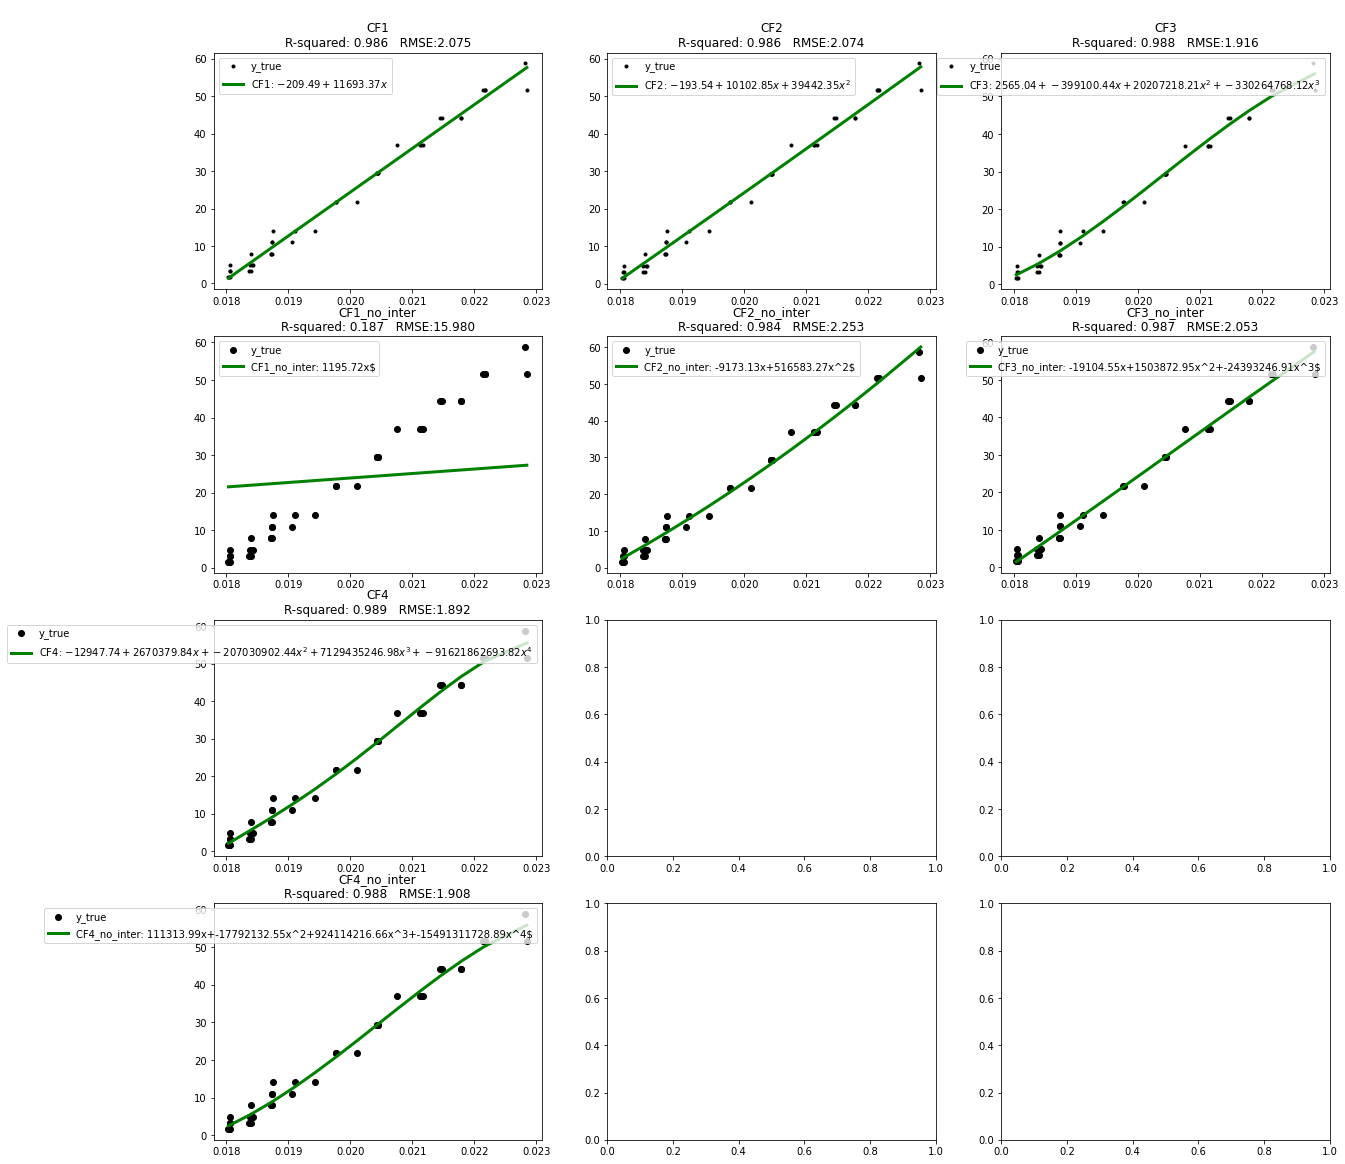

In [31]:
tempdf=DW_data[DW_data['NTU_actual']>0]
curves,curvesDic,BestOpt=PolyFitResults(tempdf['Perc_IR_UVL'],tempdf['NTU_actual'])

In [26]:
curvesDic['CF2']

array([ 21063.00678202, -42559.5767599 ,  21494.43731115])

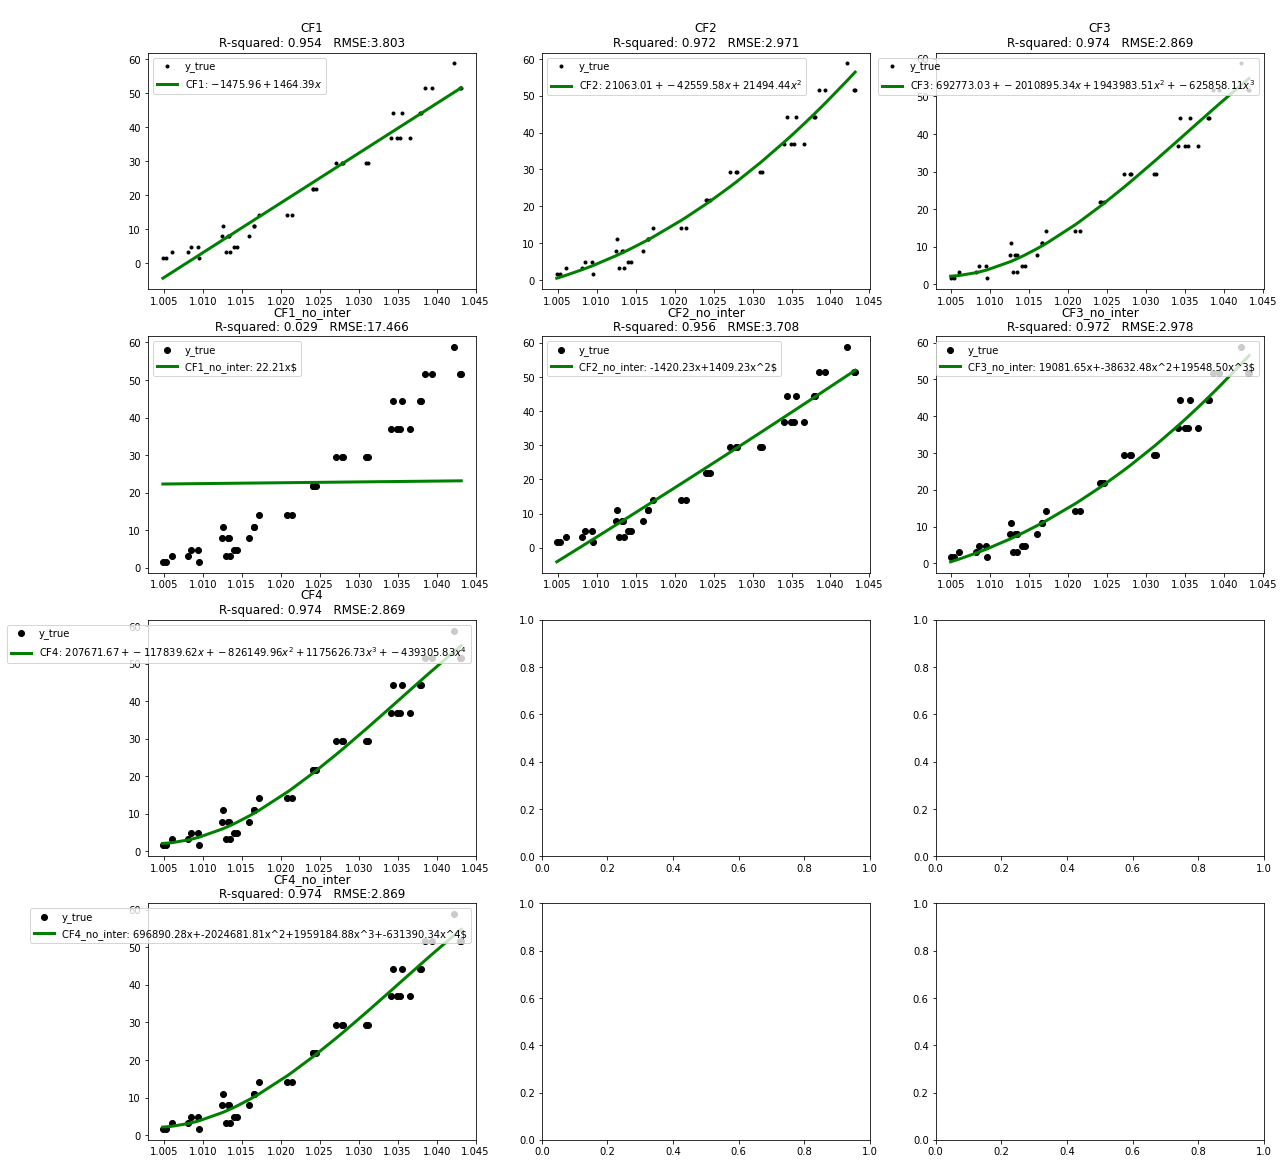

In [25]:
tempdf=DW_data[DW_data['NTU_actual']>0]
curves,curvesDic,BestOpt=PolyFitResults(tempdf['Perc_IR_UVH'],tempdf['NTU_actual'])

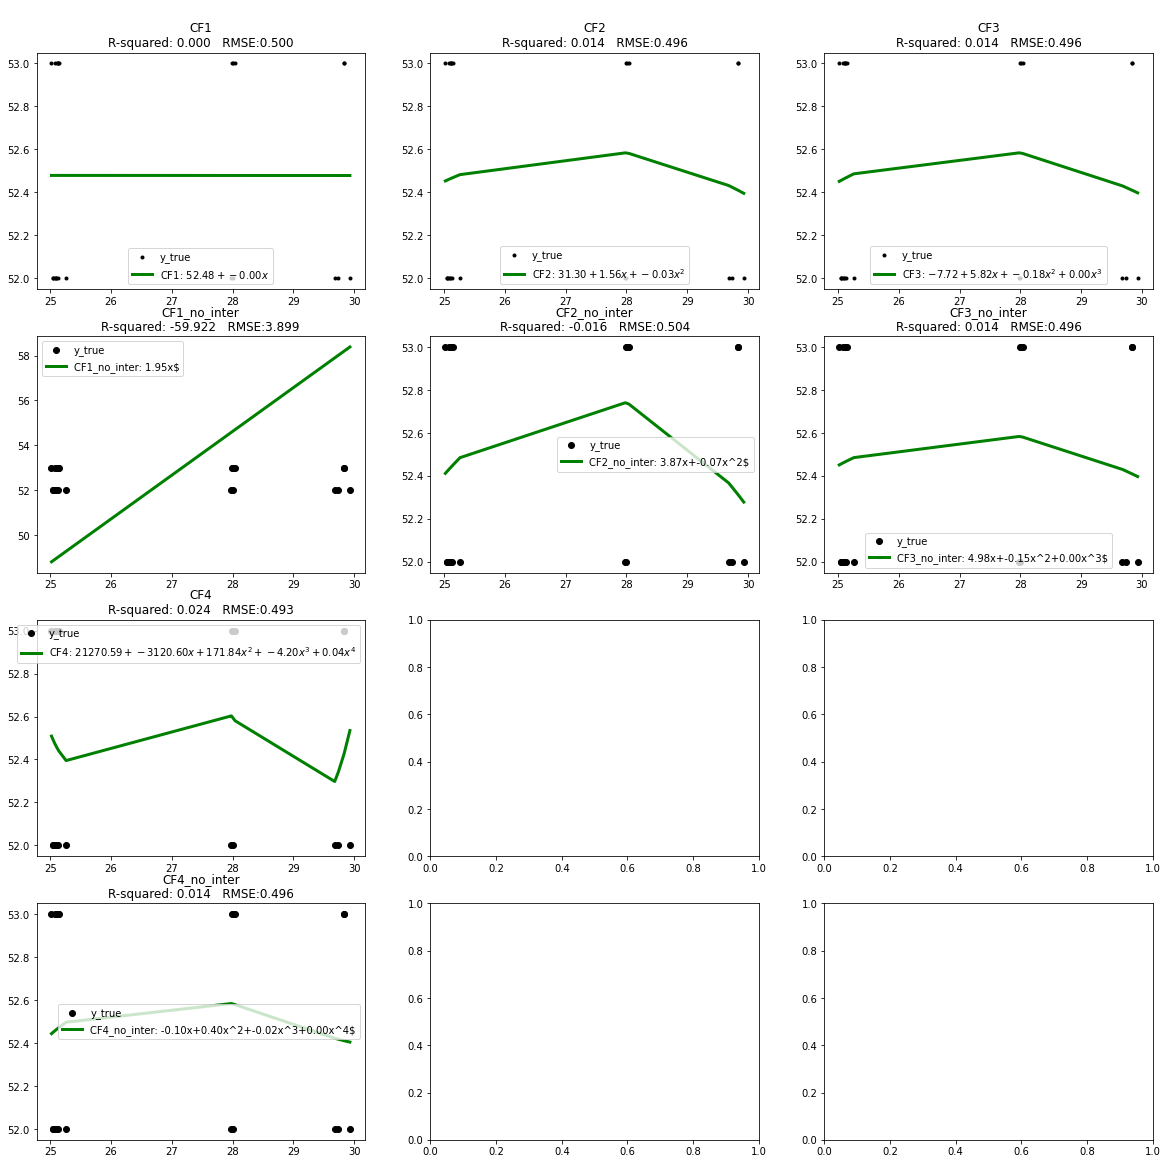

In [41]:
tempdf=DW_data[DW_data['NTU_actual']==0]
curves,curvesDic,BestOpt=PolyFitResults(tempdf['T'],tempdf['IR_UVL_t'])

In [40]:
curvesDic['CF1']

array([346.51064949,  -2.38189209])

In [ ]:
tempdf=DW_data[DW_data['NTU_actual']==0]
curves,curvesDic,BestOpt=PolyFitResults(tempdf['T'],tempdf['IR_UVH_t'])

In [ ]:
tempdf=DW_data[DW_data['NTU_actual']>0]
curves,curvesDic,BestOpt=PolyFitResults(tempdf['Perc_IR_IR_t'],tempdf['NTU_actual'])

In [132]:
curvesDic['CF1']

array([ 7010.62947361, -7010.7520486 ])

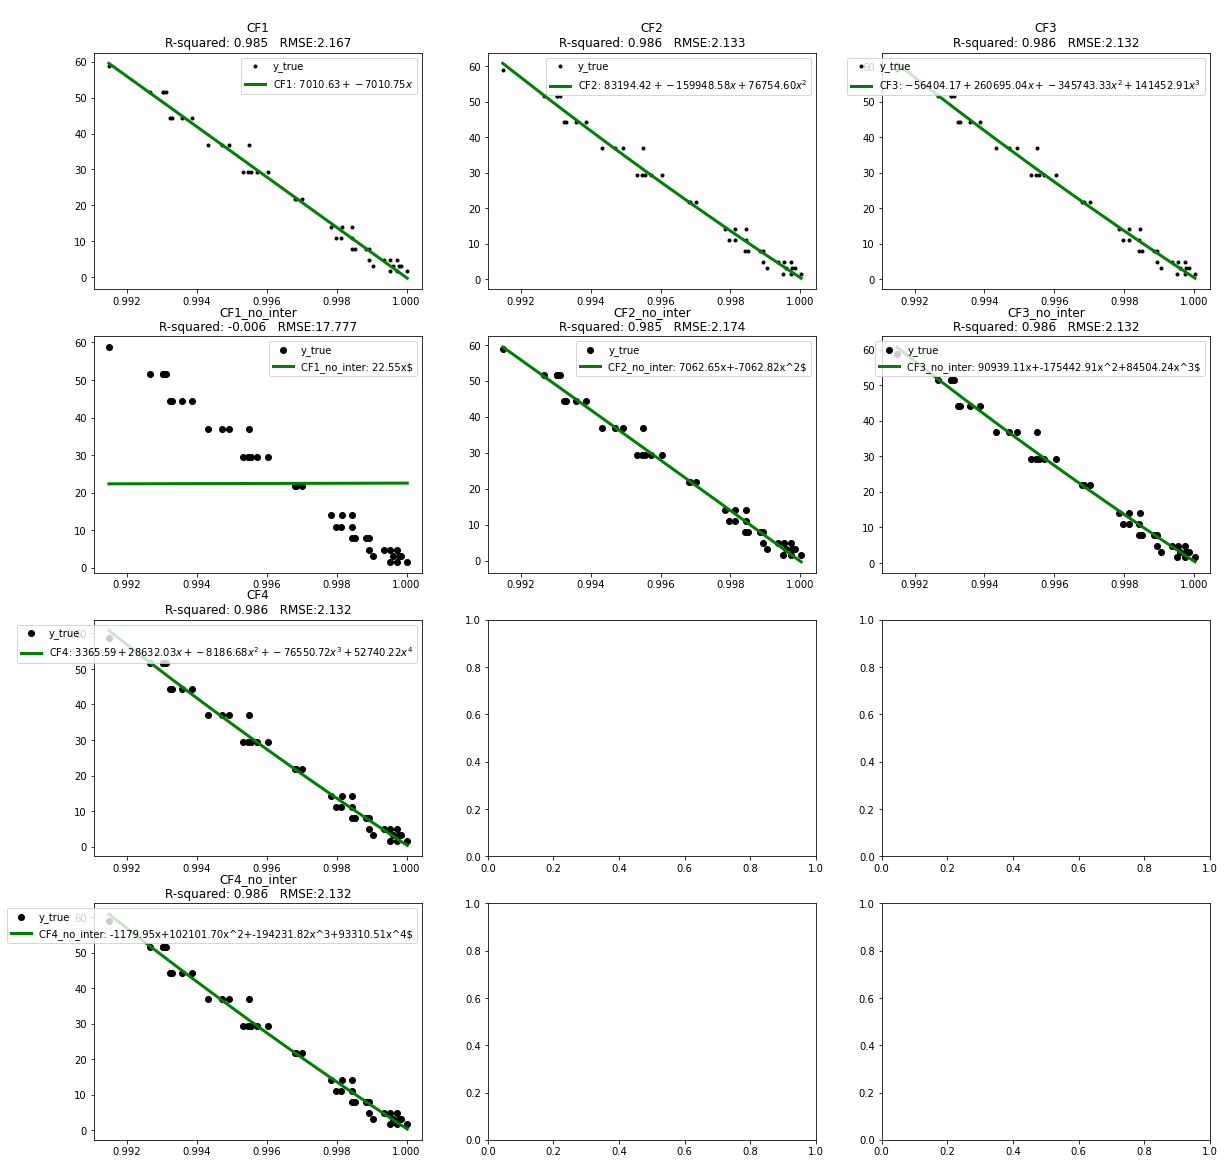

In [20]:
tempdf=DW_data[DW_data['NTU_actual']>0]
curves,curvesDic,BestOpt=PolyFitResults(tempdf['Perc_IR_IR_t'],tempdf['NTU_actual'])

In [126]:
curvesDic['CF1']

array([ 0.99820843, -0.00292697])

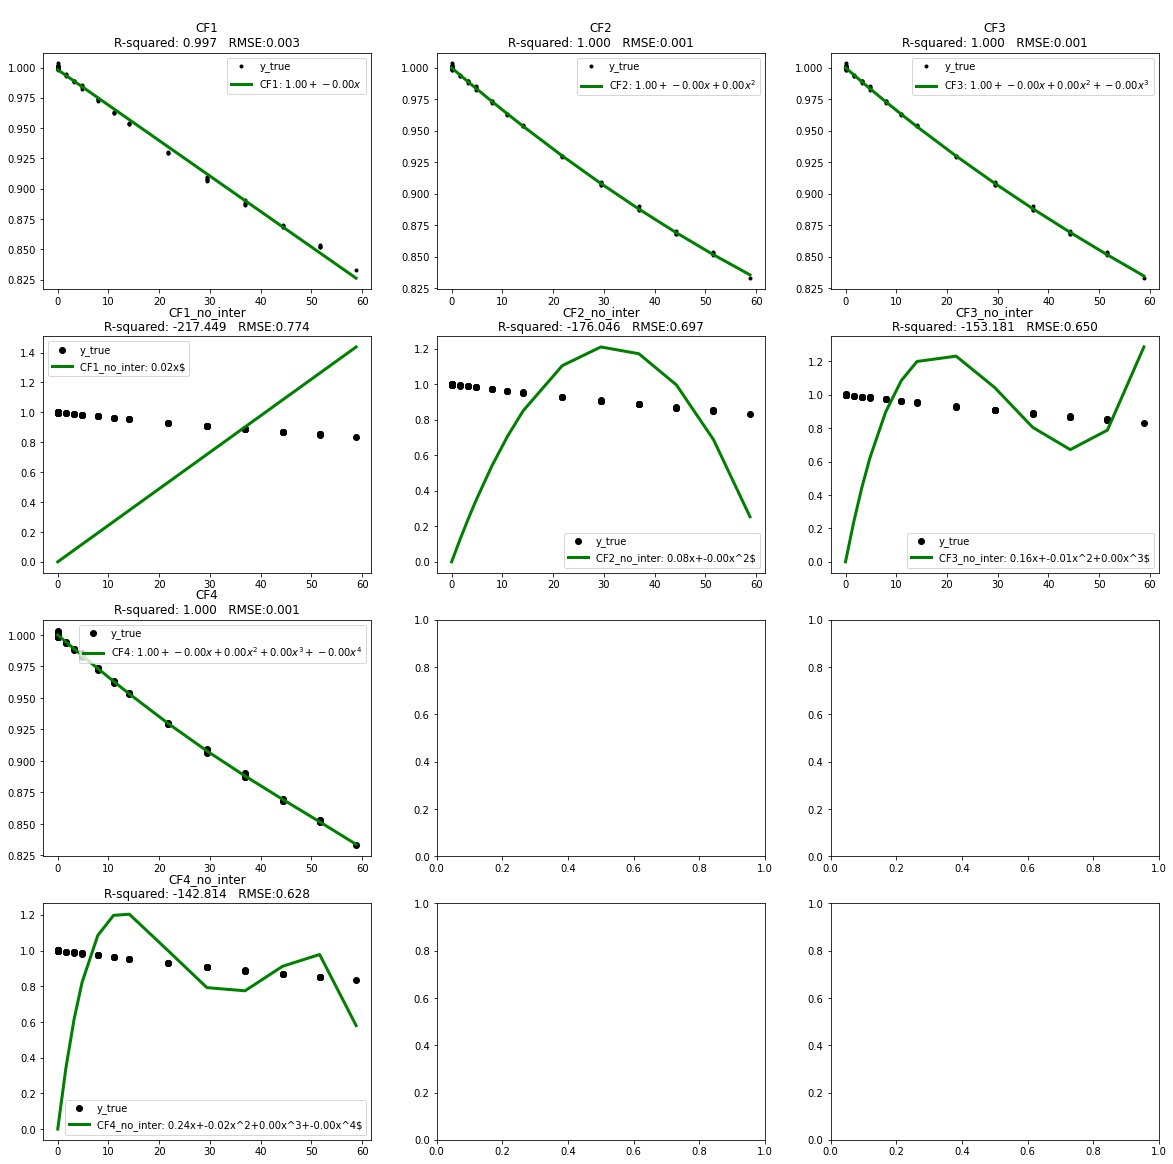

In [125]:
tempdf=DW_data
curves,curvesDic,BestOpt=PolyFitResults(tempdf['NTU_actual'],tempdf['Perc_UVL'])

In [124]:
curvesDic['CF1']

array([ 0.99845199, -0.00280821])

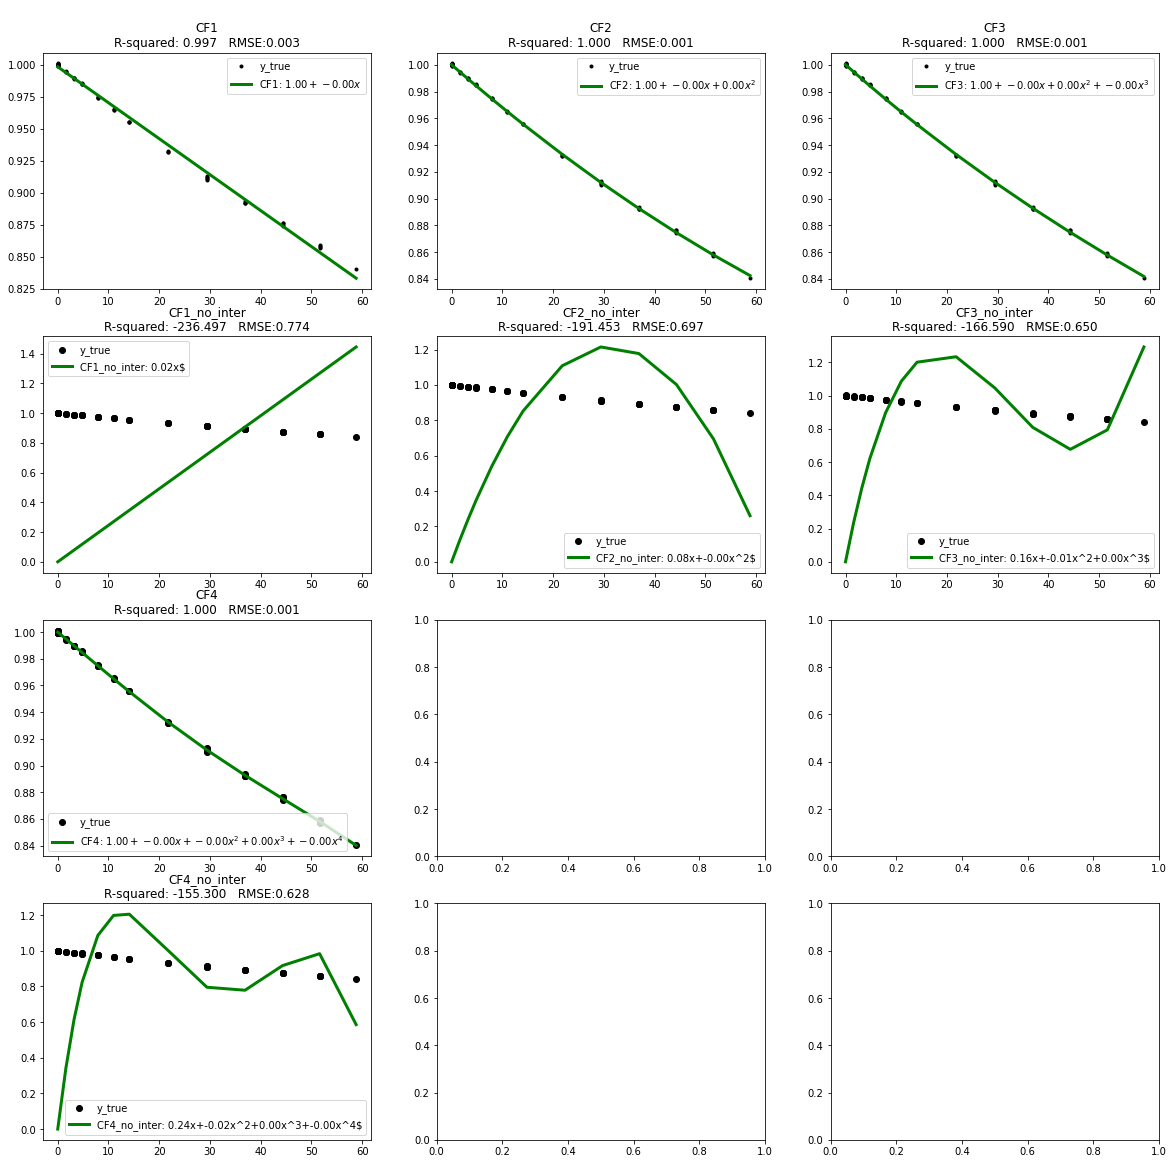

In [27]:
tempdf=DW_data
curves,curvesDic,BestOpt=PolyFitResults(tempdf['NTU_actual'],tempdf['Perc_UVH'])

In [38]:
curvesDic['CF1']

array([3646.99345406,  -12.10791791])

In [ ]:
tempdf=DW_data[DW_data['comment']=='DW_NTU_0']
curves,curvesDic,BestOpt=PolyFitResults(tempdf['T'],tempdf['UVH_UVH_t'])

In [40]:
curvesDic['CF1']

array([3908.90246823,  -32.60112903])

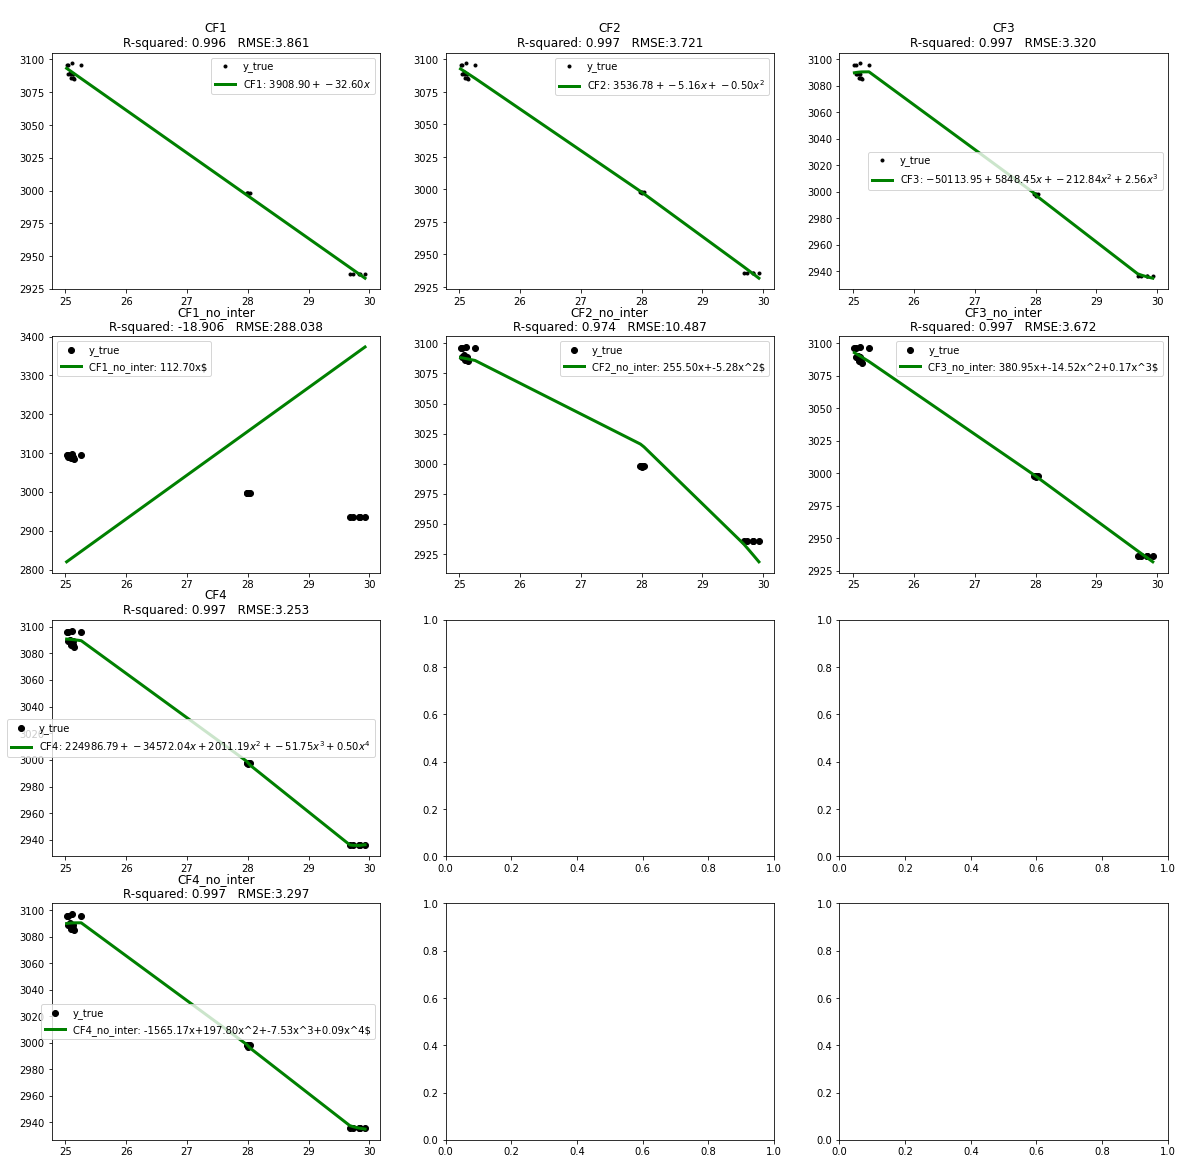

In [39]:
tempdf=DW_data[DW_data['comment']=='DW_NTU_0']
curves,curvesDic,BestOpt=PolyFitResults(tempdf['T'],tempdf['UVL_UVL_t'])

ניקח 490 קבוע SCATTER ב DW

In [42]:
curvesDic['CF1']

array([3846.3408248 ,  -14.44308135])

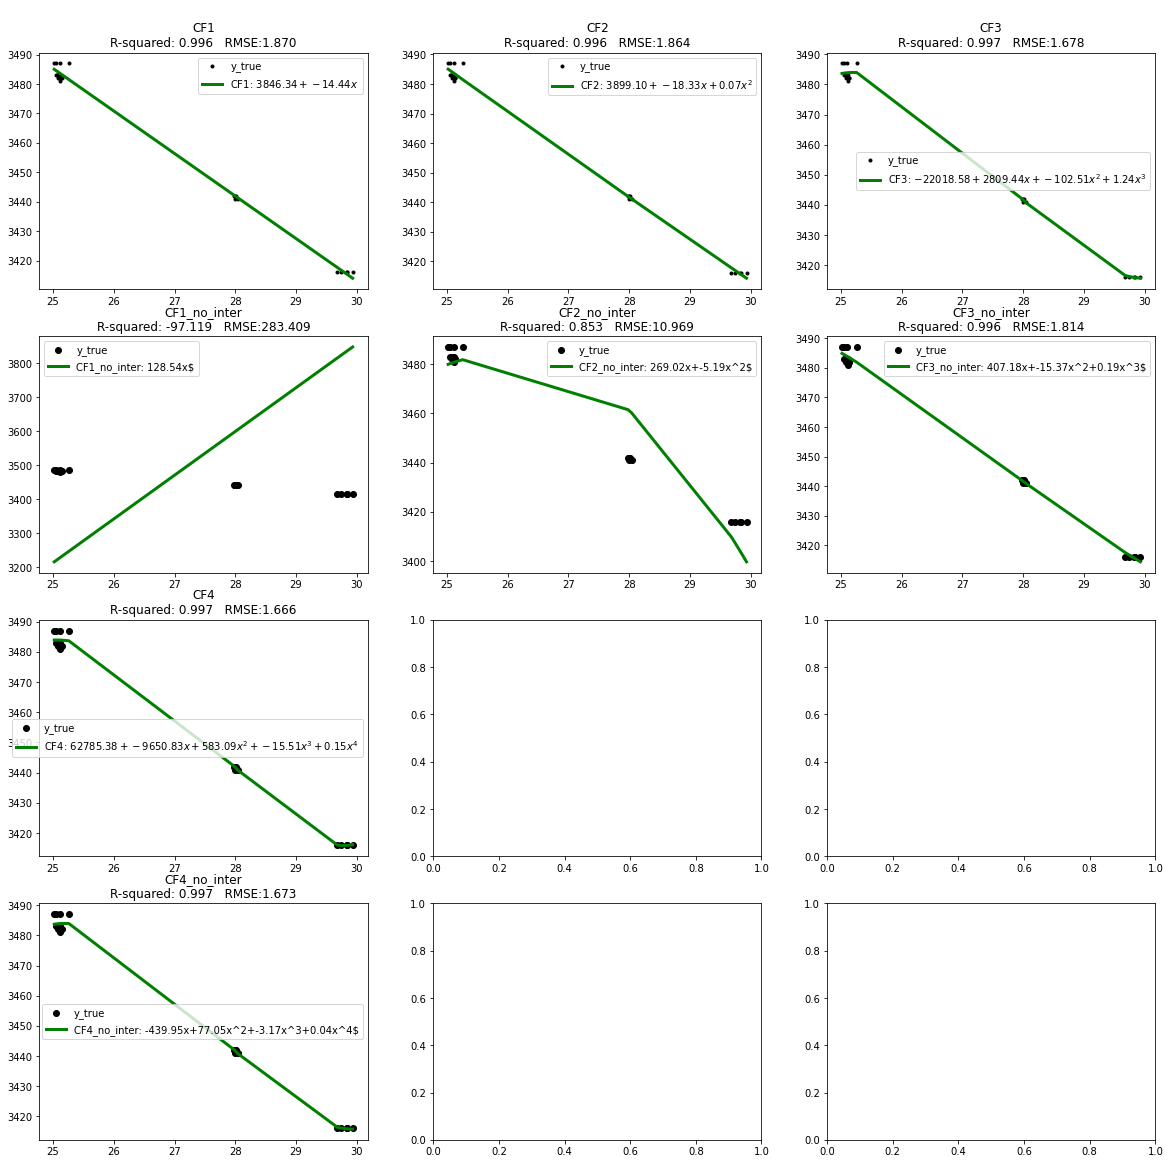

In [45]:
tempdf=DW_data[DW_data['comment']=='DW_NTU_0']
curves,curvesDic,BestOpt=PolyFitResults(tempdf['T'],tempdf['IR_IR_t'])

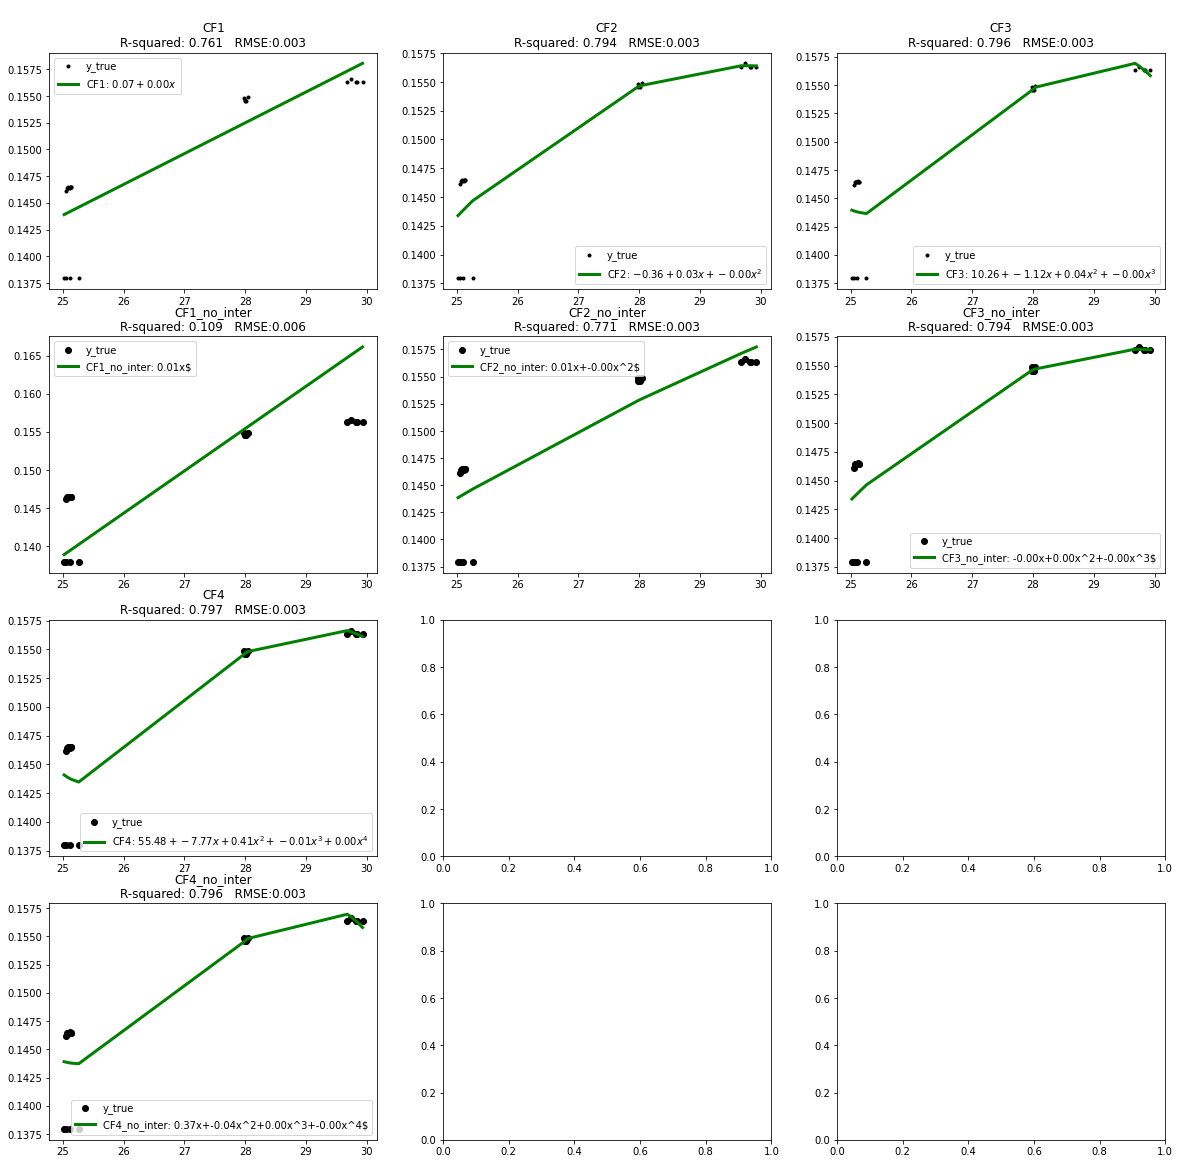

In [43]:
tempdf=DW_data[DW_data['comment']=='DW_NTU_0']
curves,curvesDic,BestOpt=PolyFitResults(tempdf['T'],tempdf['IR_IR_s']/tempdf['IR_IR_t'])